# Policy Gradients

## Torch

In [1]:
from policy_model import MultiLayerModel, PyTorchWrapper
import gymnasium as gym
import torch
device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)

In [49]:
env_name = "LunarLander-v2"
# env_name = "CartPole-v1"

env = PyTorchWrapper(gym.make(env_name))
observation_space = env.observation_space.shape[0]
action_space = env.action_space.n
env.close()

policy_model_layers = [128, 64, 64]
policy_model = MultiLayerModel(observation_space, action_space, policy_model_layers, output_activation=torch.nn.Softmax).to(device)

value_model_layers = [64, 64]
value_model = MultiLayerModel(observation_space, 1, value_model_layers, output_activation=None).to(device)

In [50]:
def compute_returns(rewards, gamma=1.0):
    returns = []
    R = 0
    for r in rewards[::-1]:
        R = r + gamma * R
        returns.insert(0, R)
    return torch.tensor(returns, dtype=torch.float32)

def update_policy(model, lst_return, lst_action_probs, lst_grads, lst_value_ests, lr):
    for return_val, action_prob, parameter_grads, value_est in zip(lst_return, lst_action_probs, lst_grads, lst_value_ests):
        multiplier = lr * (return_val - value_est) / action_prob
        for param, stored_grad in zip(model.parameters(), parameter_grads):
            if param.grad is not None:
                param.data += multiplier * stored_grad
                
def update_value(model, lst_return, lst_value_ests, lst_grads, lr):
    for return_val, value_est, parameter_grads in zip(lst_return, lst_value_ests, lst_grads):
        multiplier = lr * (return_val - value_est)
        for param, stored_grad in zip(model.parameters(), parameter_grads):
            if param.grad is not None:
                param.data += multiplier * stored_grad


# Configuration
n_episodes = 5000
n_steps = 500
lr_policy = 0.00001
lr_value = 0.001
check_n = 30
gamma = 0.99#0.99

# Environment and Model Setup
env = PyTorchWrapper(gym.make(env_name))

# Lists to track episode statistics
episode_lengths = []
episode_mean_returns = []

# Training Loop
for i_episode in range(n_episodes):
    observation, _ = env.reset()
    lst_rewards, lst_action_probs, lst_policy_grads, lst_value_ests, lst_value_grads  = [], [], [], [], []

    for _ in range(n_steps):
        
        # Sample action from policy model and record probability
        action_dist = policy_model(observation)
        action = torch.multinomial(action_dist, 1)
        lst_action_probs.append(action_dist[action])

        # Step environment and record reward
        observation, reward, terminated, truncated, _ = env.step(action.item())
        lst_rewards.append(reward)
        
        # Compute value estimate and gradient
        value_est = value_model(observation)
        lst_value_ests.append(value_est)
        value_model.zero_grad()
        value_est.backward()
        lst_value_grads.append([param.grad.clone() for param in value_model.parameters() if param.grad is not None])
        
        # Compute policy gradient and record
        policy_model.zero_grad()
        action_dist[action].backward()
        lst_policy_grads.append([param.grad.clone() for param in policy_model.parameters() if param.grad is not None])

        if terminated or truncated:
            break

    returns = compute_returns(lst_rewards, gamma)
    update_policy(policy_model, returns, lst_action_probs, lst_policy_grads, lst_value_ests, lr_policy)
    update_value(value_model, returns, lst_value_ests, lst_value_grads, lr_value)


    episode_lengths.append(len(lst_rewards))
    episode_mean_returns.append(returns.mean().item())

    if (i_episode + 1) % check_n == 0:
        avg_steps = sum(episode_lengths[-check_n:]) / check_n
        avg_mean_return = sum(episode_mean_returns[-check_n:]) / check_n
        print(f"Episodes {i_episode+1-check_n}-{i_episode+1} | Average Steps: {avg_steps}, Average Mean Return: {avg_mean_return}")


env.close()

RuntimeError: probability tensor contains either `inf`, `nan` or element < 0

In [45]:
# Save torch model
torch.save(policy_model.state_dict(), f"{env_name}.pt")

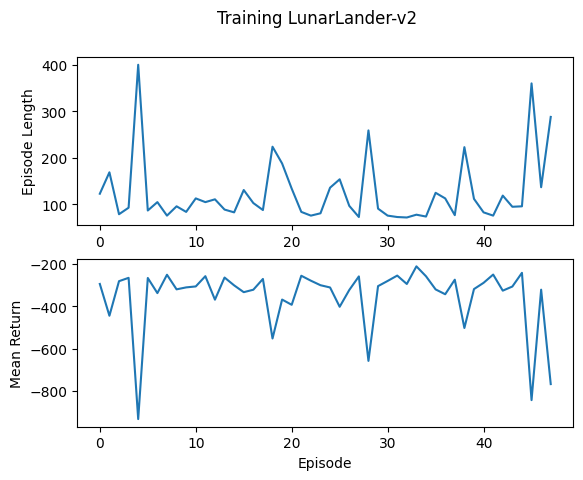

In [46]:
import matplotlib.pyplot as plt
# Multi plot for episode lengths and mean returns
fig, axs = plt.subplots(2)
fig.suptitle(f"Training {env_name}")
axs[0].plot(episode_lengths)
axs[0].set_ylabel("Episode Length")
# Add moving average
n = 60
cumsum, moving_aves = [0], []
for i, x in enumerate(episode_lengths, 1):
    cumsum.append(cumsum[i-1] + x)
    if i >= n:
        moving_ave = (cumsum[i] - cumsum[i-n])/n
        moving_aves.append(moving_ave)
axs[0].plot(moving_aves)

axs[1].plot(episode_mean_returns)
axs[1].set_ylabel("Mean Return")
axs[1].set_xlabel("Episode")
cumsum, moving_aves = [0], []
for i, x in enumerate(episode_mean_returns, 1):
    cumsum.append(cumsum[i-1] + x)
    if i >= n:
        moving_ave = (cumsum[i] - cumsum[i-n])/n
        moving_aves.append(moving_ave)
axs[1].plot(moving_aves)
plt.show()

In [7]:
env = PyTorchWrapper(gym.make(env_name, render_mode="human"))
# env = PyTorchWrapper(gym.make("CartPole-v1", render_mode="human"))
n_steps = 1000
observation, info = env.reset()
for _ in range(n_steps):
    env.render()
    action_dist = policy_model(observation)
    action = torch.argmax(action_dist)
    observation, reward, terminated, truncated, info = env.step(action.item())

    if terminated or truncated:
        break

env.close()
